In [22]:
using KitBase, Plots, JLD2, Distributions, LinearAlgebra, Flux
using Flux: onecold, @epochs

In [13]:
function regime_data(w, sw, f, u, K, Kn, μ=ref_vhs_vis(Kn, 1.0, 0.5), ω=0.81)
    gam = heat_capacity_ratio(K, 1)
    prim = conserve_prim(w, gam)
    Mu, Mxi, _, _1 = gauss_moments(prim, K)
    a = pdf_slope(prim, sw, K)
    swt = -prim[1] .* moments_conserve_slope(a, Mu, Mxi, 1)
    A = pdf_slope(prim, swt, K)
    tau = vhs_collision_time(prim, μ, ω)
    fr = chapman_enskog(u, prim, a, A, tau)
    L = norm((f .- fr) ./ prim[1])

    x = [w; sw; tau]
    y = ifelse(L <= 0.005, [1.0, 0.0], [0.0, 1.0])
    return x, y
end

function regime_number(Y, rg=1)
   idx = 0
    for i in axes(Y, 2)
       if Y[1, i] == rg
            idx += 1
        end
    end
    println("NS regime: $(idx) of $(size(Y, 2))")
    return nothing
end

function accuracy(nn, X, Y)
    Y1 = nn(X)

    YA1 = [onecold(Y1[:, i]) for i in axes(Y1, 2)]
    YA = [onecold(Y[:, i]) for i in axes(Y, 2)]

    accuracy = 0.0
    for i in eachindex(YA)
        if YA[i] == YA1[i]
            accuracy += 1.0
        end
    end
    accuracy /= length(YA)

    return accuracy
end

accuracy (generic function with 1 method)

### Dataset

In [3]:
file = open("/home2/vavrines/Coding/KiT-RT/result/logs/test_a3_ev5_2.csv")
data = []
for line in eachline(file)
    a = split(line, ",")
    b = [parse(Float64, a[i]) for i = 2:length(a)]
    push!(data, b)
end
pdfs = data[3:end]
nd = length(pdfs) ÷ 2

500

In [4]:
vs = VSpace1D(-5.0, 5.0, length(data[1]), data[1], data[1][2:end] .- data[1][1:end-1], data[2])

VelocitySpace1D{Float64,Int64,Vector{Float64},Vector{Float64}}
domain: (-5.0,5.0)
resolution: 100
ghost: 0


In [5]:
dist = Uniform(0.0001, 0.1)
dxs = rand(dist, nd)
dist = Uniform(0.000001, 1.0)
kns = rand(dist, nd);

In [6]:
X = zeros(7, nd)
Y = zeros(2, nd)
for i = 1:nd
    #fL = pdfs[i]; fR = pdfs[nd*2-i]
    fL = pop!(pdfs); fR = pop!(pdfs) # shuffle
    wL = moments_conserve(fL, vs.u, vs.weights); wR = moments_conserve(fR, vs.u, vs.weights)
    #@show wL, wR
    w = @. (wL + wR) / 2
    sw = @. (wR - wL) / dxs[i]
    f = @. (fL + fR) / 2
    
    X[:, i], Y[:, i] = regime_data(w, sw, f, vs.u, 0, kns[i])
end

In [7]:
regime_number(Y)

NS regime: 103 of 500


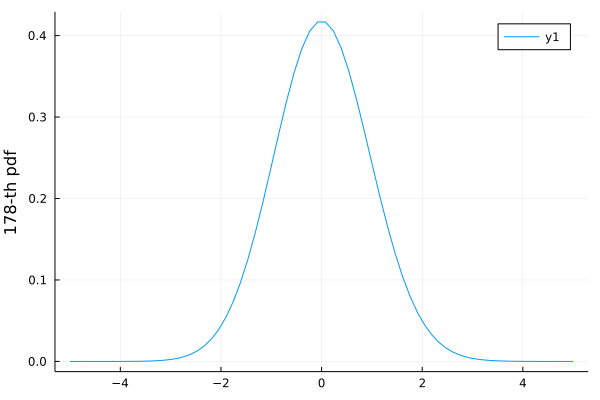

In [8]:
idx = Int(floor(rand() * size(X, 2)))
plot(data[1], data[idx], ylabel="$(idx)-th pdf")

### Model

In [9]:
@load "../nn.jld2" nn

1-element Vector{Symbol}:
 :nn

In [16]:
accuracy(nn, X, Y)

0.792

In [24]:
data = Flux.Data.DataLoader((X, Y), shuffle = true)
ps = Flux.params(nn)
sqnorm(x) = sum(abs2, x)
loss(x, y) = sum(abs2, nn(x) - y) / size(x, 2) #+ 1e-6 * sum(sqnorm, ps)
cb = () -> println("loss: $(loss(X, Y))")
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}())

In [26]:
@epochs 100 Flux.train!(loss, ps, data, opt, cb = Flux.throttle(cb, 1))

loss: 0.2865936387093781


┌ Info: Epoch 1
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2844522746214717


┌ Info: Epoch 2
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.28842323999469355
loss: 0.2818765047195047


┌ Info: Epoch 3
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 4
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2786341450178247


┌ Info: Epoch 5
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.28276115268210317


┌ Info: Epoch 6
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2780040988534988
loss: 0.2743536211834875


┌ Info: Epoch 7
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 8
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.27921401949636504


┌ Info: Epoch 9
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.290085044016791


┌ Info: Epoch 10
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2638330758374741
loss: 0.26161749766519427


┌ Info: Epoch 11
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 12
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.26862882174747615


┌ Info: Epoch 13
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2940898523968339


┌ Info: Epoch 14
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.3029309679596423


┌ Info: Epoch 15
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2665588125914212
loss: 0.2551616117032353


┌ Info: Epoch 16
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 17
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2534773630317041


┌ Info: Epoch 18
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2558682315477883


┌ Info: Epoch 19
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2527191592284318


┌ Info: Epoch 20
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.25690527595217205
loss: 0.27268851429463925


┌ Info: Epoch 21
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 22
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2572204347202314


┌ Info: Epoch 23
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2548691183768451


┌ Info: Epoch 24
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2540527349738174
loss: 0.25745167055605067


┌ Info: Epoch 25
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 26
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.25057771684068547


┌ Info: Epoch 27
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2558525140595919


┌ Info: Epoch 28
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.25453909079167136
loss: 0.2654674530330756


┌ Info: Epoch 29
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 30
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2508282345187434


┌ Info: Epoch 31
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.24605517546518738


┌ Info: Epoch 32
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.24843300909206278
loss: 0.24603689621807356


┌ Info: Epoch 33
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 34
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2493429610997691


┌ Info: Epoch 35
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.24216166753464077


┌ Info: Epoch 36
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.24212517673021103


┌ Info: Epoch 37
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2507954124776118
loss: 0.23951194750333507


┌ Info: Epoch 38
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 39
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.24619301843254085


┌ Info: Epoch 40
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.24786868240095725


┌ Info: Epoch 41
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.24991666521180927


┌ Info: Epoch 42
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2423116189260524
loss: 0.23787779559329977


┌ Info: Epoch 43
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 44
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23894732763474252


┌ Info: Epoch 45
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2447284587564286


┌ Info: Epoch 46
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2401743465857877


┌ Info: Epoch 47
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2388539493233805
loss: 0.24841471725184333


┌ Info: Epoch 48
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 49
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2463911739624983


┌ Info: Epoch 50
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2390751576781648


┌ Info: Epoch 51
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23920879822245503
loss: 0.2421901067112119


┌ Info: Epoch 52
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 53
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2490301646588407


┌ Info: Epoch 54
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2332229466673936


┌ Info: Epoch 55
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23641997267472095


┌ Info: Epoch 56
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.24216026149349135
loss: 0.23502410870634083


┌ Info: Epoch 57
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 58
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23593942395612955


┌ Info: Epoch 59
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2300281259615668


┌ Info: Epoch 60
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23008944573811493


┌ Info: Epoch 61
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 62
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22888367826274192
loss: 0.2323898249165552


┌ Info: Epoch 63
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22843249798077017


┌ Info: Epoch 64
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23243659764986366


┌ Info: Epoch 65
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2277206365532568
loss: 0.23718287404404279


┌ Info: Epoch 66
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 67
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23331849549121886


┌ Info: Epoch 68
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23086071134536984


┌ Info: Epoch 69
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2362517058682428


┌ Info: Epoch 70
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22895422901038415
loss: 0.22810306813565234


┌ Info: Epoch 71
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 72
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2238968951089272


┌ Info: Epoch 73
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23010395162068237


┌ Info: Epoch 74
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.223072708941804


┌ Info: Epoch 75
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22346136046433243
loss: 0.22549886822047707


┌ Info: Epoch 76
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 77
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22232298137127596


┌ Info: Epoch 78
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2223641089227923


┌ Info: Epoch 79
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2212041203668854
loss: 0.22601970505538682


┌ Info: Epoch 80
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 81
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22244418956495562


┌ Info: Epoch 82
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2246360745194686


┌ Info: Epoch 83
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22189041360082323


┌ Info: Epoch 84
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22094116174477454
loss: 0.2256525709446751


┌ Info: Epoch 85
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 86
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2195256964679645


┌ Info: Epoch 87
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22475999246367845


┌ Info: Epoch 88
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2218097124047228
loss: 0.21689913993977394


┌ Info: Epoch 89
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 90
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2213118200700739


┌ Info: Epoch 91
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.21651671147163745


┌ Info: Epoch 92
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.21558709917200225


┌ Info: Epoch 93
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.2235327712804111
loss: 0.2214723261149491


┌ Info: Epoch 94
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 95
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.23104368060900485


┌ Info: Epoch 96
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22288226338513878


┌ Info: Epoch 97
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.22616001071448624
loss: 0.2183269702430555


┌ Info: Epoch 98
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138
┌ Info: Epoch 99
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


loss: 0.21318292998360303


┌ Info: Epoch 100
└ @ Main /home2/vavrines/.julia/packages/Flux/BPPNj/src/optimise/train.jl:138


In [29]:
cd(@__DIR__)

In [30]:
@save "nn.jld2" nn

### Test

In [28]:
accuracy(nn, X, Y)

0.858